# Estimating the gradient of a quadratic potential function using Jordan's quantum gradient estimation algorithm (10.1103/PhysRevLett.95.050501).

First, import libraries needed for plotting and data manipulation.

Additionally, we will import patch from mock so that we can simulate connecting to the quantum computer.

Also import the estimate_gradient module in Grove, which invokes the quantum gradient estimator.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from mock import patch

from grove.alpha.jordan_gradient.jordan_gradient import estimate_gradient

In [2]:
%matplotlib inline

We need to query this potential at a perturbation h from the point at which we are estimating the gradient.  

With future developments, we will not have to specify this function.  For example, suppose we were interested in simulating chemical dynamics. In such a case, we would retrieve the potential values at perturbation h from an electronic structure calculation.

Here we are estimating the gradient at a variable set of domain values within in a quadratic potential (also referred to as a harmonic oscillator, or spring).  This potential is defined by a spring constant, k, and is given by the following equation:
$$V = \frac{1}{2}k x^2$$ 
Also note that this gradient estimation technique is only valid over the domain ``[0, 1)``, so we will center the potential at ``x=.5``, and set highly repulsive barriers at values less than 0 and greater than or equal to 1.

In [3]:
SPRING_CONSTANT = 1
POTENTIAL_BARRIER_VALUE = 100
DOMAIN_SHIFT = .5

In [4]:
def oracle_potential(x):
    if (x < 0) or (x >= 1):
        y = POTENTIAL_BARRIER_VALUE
    else:
        y = .5 * SPRING_CONSTANT * (x-DOMAIN_SHIFT)**2
    return y

In [5]:
def potential_perturbation(x_eval, h):
    f_h = (oracle_potential(x_eval+h) - oracle_potential(x_eval-h)) / (2*h)
    return f_h

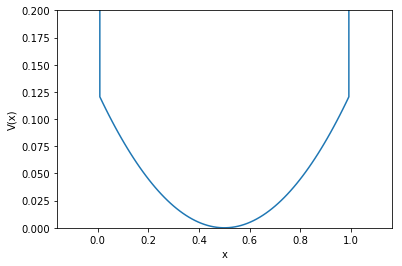

In [6]:
# visualize the potential
x = np.linspace(-.1, 1.1, 100)
y = [oracle_potential(i) for i in x]
plt.plot(x,y)
plt.ylim([0,.2])
plt.xlabel('x')
plt.ylabel('V(x)')

We will also compute the gradient of this potential analytically, so that we may benchmark the accuracy of the estimator.

In [7]:
# reference for computing error
def analytic_gradient(x):
    if x < 0:
        g = -1 * POTENTIAL_BARRIER_VALUE
    elif x >= 1:
        g = POTENTIAL_BARRIER_VALUE
    else:
        g = x - DOMAIN_SHIFT  
    return g

Now we will estimate the gradient at 4 random domain values.  So that this example is deterministic, we specify the random seed as 99.

We also need to set region over which our sampling region is approximately linear (PERTURBATION_MAGNITUDE), and the number of times to measure the system (N_MEASUREMENTS).

In [8]:
# compute gradient at 4 random points [0, 1). 
np.random.seed(99)
x_scan = np.random.rand(4)

# set constants
PERTURBATION_MAGNITUDE = .001
N_MEASUREMENTS = 50

Because we are simulating connecting to the quantum computer, here we have mock the response.  

These results were generated from running the notebook live.

If you are running live, ignore the below cell, and simply run this code:

```python
from pyquil.api import QVMConnection
qvm = QVMConnection()
```

Then, you would add ```cxn=qvm``` to the argument list when you call ```potential_gradient```

In [9]:
binary_p4 = {
    x_scan[0]: [1, 0, 0, 0],
    x_scan[1]: [0, 0, 0, 0],
    x_scan[2]: [1, 1, 0, 0],
    x_scan[3]: [0, 0, 1, 0]
}

binary_p10 = {
    x_scan[0]: [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
    x_scan[1]: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    x_scan[2]: [1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
    x_scan[3]: [0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
}

binary_maps = {
    4: binary_p4,
    10: binary_p10
}

In [10]:
def potential_gradient(x, h, n_measurements, precision, precision_map, cxn=None):
    
    # if you are running this live, input your qvm or qpu object to cxn
    if not cxn:
        with patch("pyquil.api.SyncConnection") as cxn:
            cxn.run.return_value = [precision_map[x] for i in range(n_measurements)]
    
    # function evaluation at perturbation h
    f_h = potential_perturbation(x, h)
    
    # estimate gradient, calculate error for a given precision
    gradient_V_qm = estimate_gradient(f_h, precision, n_measurements, cxn)
    gradient_V_a = analytic_gradient(x)
    ab_error = abs(gradient_V_qm - gradient_V_a)
        
    return gradient_V_qm, gradient_V_a, ab_error

The quantum gradient estimator computes in the basis of binary fractions.  For this reason, we need to specify the desired precision of the estimate. 

Here we will perform a quick experiment, scanning over the input precision value for each input point of evaluation.

In [11]:
def eval_estimator(x_vals, precision, precision_map):
    for x in x_vals:
        qm, a, error = potential_gradient(x, PERTURBATION_MAGNITUDE, N_MEASUREMENTS, precision, precision_map)
        print ('x', x, 'error', error)

In [12]:
precisions = [4, 10]
for p in precisions:
    print ('precision', p)
    eval_estimator(x_scan, p, binary_maps[p])
    print ('\n')

precision 4
x 0.672278558631 error 0.0472785586308
x 0.488078399241 error 0.0119216007594
x 0.825495174036 error 0.0495048259641
x 0.0314463876263 error 0.0314463876263


precision 10
x 0.672278558631 error 0.000403558630792
x 0.488078399241 error 0.000202850759416
x 0.825495174036 error 0.000676700964104
x 0.0314463876263 error 0.000196387626298




We see that, for a given precision, the errors are comparable for all domain values.  

Additionally, as expected, the error of the estimate improves when the precision is increased.